In [1]:
from datetime import date, timedelta
from time import strftime
from os import listdir
import pickle
import requests

import pandas as pd
# import modin.pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# https://towardsai.net/p/l/things-to-watch-out-for-while-working-with-the-mta-turnstile-data-in-2022#:~:text=Additionally%2C%20there%20may%20be%20a,missed%20audit%20that%20was%20recovered.

In [2]:
# fetch raw data files
# I copied output into shell script and downloaded in chunks with shell script
# or open directly over web with pd.read_csv and concatenate
# or download with requests

prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
suffix = ".txt"
from datetime import date, timedelta
from time import strftime

def allsaturdays(year):
    d = date(year, 1, 1)                    # January 1st
    d += timedelta(days = 6 - d.weekday())  # First Sunday
    if d.weekday() == 6: #Sunday
        d += timedelta(days = 6)
    else: 
        d += timedelta(days = 5-d.weekday())
    yield d
    while d.year == year:
        d += timedelta(days = 7)
        yield d
        
year=2022

for d in allsaturdays(year):
    inix=strftime("%y%m%d", d.timetuple())
    print("curl %s%s%s > %s%s" % (prefix, inix, suffix, inix, suffix))


curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220108.txt > 220108.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220115.txt > 220115.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220122.txt > 220122.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220129.txt > 220129.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220205.txt > 220205.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220212.txt > 220212.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220219.txt > 220219.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220226.txt > 220226.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220305.txt > 220305.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220312.txt > 220312.txt
curl http://web.mta.info/developers/data/nyct/turnstile/turnstile_220319.txt > 220319.txt
curl http:

In [3]:
# pd.read_csv(URL)

In [4]:
# fname = "turnstile_220604.txt"
# URL = "http://web.mta.info/developers/data/nyct/turnstile/%s" % fname
# response = requests.get(URL)
# open(fname, "wb").write(response.content)

In [5]:
# datadir = "mta"

# datafiles = [f for f in listdir(datadir) if f[-4:]==".txt"]

# dfs = [pd.read_csv("%s/%s" % (datadir, f)) for f in datafiles]
    
# df = pd.concat(dfs)
# df.columns = [f.strip() for f in df.columns]

# df["DATE_TIME"] = pd.to_datetime(df['DATE'] + " " + df['TIME'])

# scptemp = df['SCP'].str.split('-', expand=True)
# df['SUBUNIT'] = scptemp[0]
# df['CONTROL'] = scptemp[1]
# df['POSITION'] = scptemp[2]

# # always sort line values the same
# df['LINENAME']=[''.join(sorted(l)) for l in list(df['LINENAME'])]
# df['STATIONLINE'] = df['STATION'] + "-" + df['LINENAME']

# # remove these dupe rows
# df = df.loc[df['DESC'] != 'RECOVR AUD']

# df = df.sort_values(by=["STATIONLINE", "C/A", "UNIT", "SCP", "DATE_TIME"]).reset_index(drop=True)

# with open('mta/mta.pickle', 'wb') as handle:
#     pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# these values should prob be merged if doing any station-level dataviz or EDA
# '42 ST-PORT AUTH-1237ACEGNRSW'
# '42 ST-PORT AUTH-1237ACENQRSW'
# '59 ST-456NQRW'
# '59 ST-NRW'
# 'TIMES SQ-42 ST-1237ACENQRS'
# 'TIMES SQ-42 ST-1237ACENQRSW'
# '34 ST-PENN STA-123',
# '34 ST-PENN STA-123ACE',
# '34 ST-PENN STA-ACE',



In [6]:
with open('mta/mta.pickle', 'rb') as handle:
    df = pickle.load(handle)
len(df)


37079206

In [8]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE
0,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,03:00:00,REGULAR,14289362,16019507,2019-01-05 03:00:00,00,00,00,1 AV-L
1,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,07:00:00,REGULAR,14289390,16019637,2019-01-05 07:00:00,00,00,00,1 AV-L
2,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,11:00:00,REGULAR,14289676,16020202,2019-01-05 11:00:00,00,00,00,1 AV-L
3,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,15:00:00,REGULAR,14290302,16021021,2019-01-05 15:00:00,00,00,00,1 AV-L
4,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,19:00:00,REGULAR,14291008,16021960,2019-01-05 19:00:00,00,00,00,1 AV-L


In [9]:
# check for dupes
df \
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"]) \
 .ENTRIES.count() \
 .reset_index() \
 .sort_values("ENTRIES", ascending=False).head(10)



,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2020,03:00:00,1
24719473,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,20:00:00,1
24719467,R139,R031,04-00-00,34 ST-PENN STA,09/17/2020,20:00:00,1
24719468,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,00:00:00,1
24719469,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,04:00:00,1
24719470,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,08:00:00,1
24719471,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,12:00:00,1
24719472,R139,R031,04-00-00,34 ST-PENN STA,09/17/2021,16:00:00,1
24719474,R139,R031,04-00-00,34 ST-PENN STA,09/18/2019,00:00:00,1
24719465,R139,R031,04-00-00,34 ST-PENN STA,09/17/2020,12:00:00,1


In [10]:
# inpect dupes if any
z = df.loc[(df['C/A']=='R162') & (df['UNIT']=='R166') & (df['SCP']=='00-00-01')]
z.loc[z["DATE"]=="12/31/2020"]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE
12223530,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,00:00:00,REGULAR,110364,33870,2020-12-31 00:00:00,00,00,01,79 ST-1
12223531,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,04:00:00,REGULAR,110366,33871,2020-12-31 04:00:00,00,00,01,79 ST-1
12223532,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,08:00:00,REGULAR,110381,33887,2020-12-31 08:00:00,00,00,01,79 ST-1
12223533,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,12:00:00,REGULAR,110436,33947,2020-12-31 12:00:00,00,00,01,79 ST-1
12223534,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,16:00:00,REGULAR,110583,33992,2020-12-31 16:00:00,00,00,01,79 ST-1
12223535,R162,R166,00-00-01,79 ST,1,IRT,12/31/2020,20:00:00,REGULAR,110710,34010,2020-12-31 20:00:00,00,00,01,79 ST-1


In [11]:
#sort 
df = df.sort_values(by=["STATIONLINE", "C/A", "UNIT", "SCP", "DATE_TIME"]).reset_index(drop=True)
df


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE
0,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,03:00:00,REGULAR,14289362,16019507,2019-01-05 03:00:00,00,00,00,1 AV-L
1,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,07:00:00,REGULAR,14289390,16019637,2019-01-05 07:00:00,00,00,00,1 AV-L
2,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,11:00:00,REGULAR,14289676,16020202,2019-01-05 11:00:00,00,00,00,1 AV-L
3,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,15:00:00,REGULAR,14290302,16021021,2019-01-05 15:00:00,00,00,00,1 AV-L
4,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,19:00:00,REGULAR,14291008,16021960,2019-01-05 19:00:00,00,00,00,1 AV-L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37079201,R419,R326,00-05-01,ZEREGA AV,6,IRT,06/10/2022,05:00:00,REGULAR,39,271,2022-06-10 05:00:00,00,05,01,ZEREGA AV-6
37079202,R419,R326,00-05-01,ZEREGA AV,6,IRT,06/10/2022,09:00:00,REGULAR,39,271,2022-06-10 09:00:00,00,05,01,ZEREGA AV-6
37079203,R419,R326,00-05-01,ZEREGA AV,6,IRT,06/10/2022,13:00:00,REGULAR,39,271,2022-06-10 13:00:00,00,05,01,ZEREGA AV-6
37079204,R419,R326,00-05-01,ZEREGA AV,6,IRT,06/10/2022,17:00:00,REGULAR,39,271,2022-06-10 17:00:00,00,05,01,ZEREGA AV-6


In [12]:
# compute change in turnstile entry count by turnstile
df["ENTRIES_DIFF"] = df \
    .groupby(['STATIONLINE', 'C/A', 'UNIT', 'SCP'])['ENTRIES'] \
    .diff() \
    .fillna(0)


In [13]:
df.columns


Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME', 'SUBUNIT', 'CONTROL',
       'POSITION', 'STATIONLINE', 'ENTRIES_DIFF'],
      dtype='object')

In [14]:
# some rows where possibly maintenance was done and counter rolled over, should be 1%
df.loc[df["ENTRIES_DIFF"] < 0]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF
40316,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,09:31:08,REGULAR,18,2,2022-04-21 09:31:08,02,00,00,1 AV-L,-501441.0
45249,H007A,R248,02-00-01,1 AV,L,BMT,03/05/2022,19:00:00,REGULAR,46,24,2022-03-05 19:00:00,02,00,01,1 AV-L,-316308.0
50598,H007A,R248,02-00-02,1 AV,L,BMT,03/28/2022,16:00:00,REGULAR,65,27,2022-03-28 16:00:00,02,00,02,1 AV-L,-267708.0
55673,H007A,R248,02-00-03,1 AV,L,BMT,03/05/2022,19:00:00,REGULAR,30,94,2022-03-05 19:00:00,02,00,03,1 AV-L,-191864.0
61169,H007A,R248,02-00-04,1 AV,L,BMT,04/21/2022,20:00:00,REGULAR,78,276,2022-04-21 20:00:00,02,00,04,1 AV-L,-212109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36976162,R108A,R305,05-00-01,WTC-CORTLANDT,1,IRT,12/14/2019,08:00:00,REGULAR,28494,104595,2019-12-14 08:00:00,05,00,01,WTC-CORTLANDT-1,-22877.0
37015018,N530,R301,00-00-00,YORK ST,F,IND,07/21/2020,13:00:00,REGULAR,105,331,2020-07-21 13:00:00,00,00,00,YORK ST-F,-16405579.0
37015169,N530,R301,00-00-00,YORK ST,F,IND,08/15/2020,17:00:00,REGULAR,150,336,2020-08-15 17:00:00,00,00,00,YORK ST-F,-22556.0
37015822,N530,R301,00-00-00,YORK ST,F,IND,12/02/2020,12:00:00,REGULAR,109,534,2020-12-02 12:00:00,00,00,00,YORK ST-F,-99665.0


In [15]:
z = df.loc[df["STATIONLINE"]=="1 AV-L"].copy()
z = z.loc[(z['C/A']=="H007A") & (df["UNIT"]=="R248") & (df['SCP']=='02-00-00')]
z.loc[z["DATE"] =="04/21/2022"]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF
40313,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,00:00:00,REGULAR,501459,81210,2022-04-21 00:00:00,02,00,00,1 AV-L,0.0
40314,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,04:00:00,REGULAR,501459,81218,2022-04-21 04:00:00,02,00,00,1 AV-L,0.0
40315,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,08:00:00,REGULAR,501459,81227,2022-04-21 08:00:00,02,00,00,1 AV-L,0.0
40316,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,09:31:08,REGULAR,18,2,2022-04-21 09:31:08,02,00,00,1 AV-L,-501441.0
40317,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,12:00:00,REGULAR,90,17,2022-04-21 12:00:00,02,00,00,1 AV-L,72.0
40318,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,13:24:04,REGULAR,127,24,2022-04-21 13:24:04,02,00,00,1 AV-L,37.0
40319,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,16:00:00,REGULAR,241,37,2022-04-21 16:00:00,02,00,00,1 AV-L,114.0
40320,H007A,R248,02-00-00,1 AV,L,BMT,04/21/2022,20:00:00,REGULAR,419,60,2022-04-21 20:00:00,02,00,00,1 AV-L,178.0


In [16]:
# fix <=0
# sometimes maintenance is done, resets turnstile counter
df.loc[df["ENTRIES_DIFF"] < 0, "ENTRIES_DIFF"] = 0


In [17]:
# 1 every 5 seconds for 4 hours is probably too many
sanity_check = 3600*4 / 4

In [18]:
df.loc[df["ENTRIES_DIFF"] > sanity_check]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF
7681,H007,R248,00-00-01,1 AV,L,BMT,04/02/2019,20:00:00,REGULAR,60079006,37706430,2019-04-02 20:00:00,00,00,01,1 AV-L,3.980000e+03
74093,H007A,R248,02-03-00,1 AV,L,BMT,11/29/2021,07:00:00,REGULAR,1562968059,1562966250,2021-11-29 07:00:00,02,03,00,1 AV-L,1.562854e+09
99299,H007A,R248,02-05-00,1 AV,L,BMT,02/17/2021,19:00:00,REGULAR,262144,0,2021-02-17 19:00:00,02,05,00,1 AV-L,2.621440e+05
99496,H007A,R248,02-05-00,1 AV,L,BMT,03/22/2021,20:00:00,REGULAR,524292,63,2021-03-22 20:00:00,02,05,00,1 AV-L,2.621450e+05
99557,H007A,R248,02-05-00,1 AV,L,BMT,04/04/2021,12:00:00,REGULAR,262146,0,2021-04-04 12:00:00,02,05,00,1 AV-L,2.621370e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36729716,N094,R029,01-06-01,WORLD TRADE CTR,23ACE,IND,09/04/2020,04:00:00,REGULAR,447613,97826,2020-09-04 04:00:00,01,06,01,WORLD TRADE CTR-23ACE,3.276800e+04
36844313,R107,R305,00-03-02,WTC-CORTLANDT,1,IRT,06/05/2021,05:00:00,REGULAR,1418346,105859,2021-06-05 05:00:00,00,03,02,WTC-CORTLANDT-1,1.114112e+06
36856343,R107,R305,00-05-01,WTC-CORTLANDT,1,IRT,02/04/2020,08:00:00,REGULAR,5701634,116,2020-02-04 08:00:00,00,05,01,WTC-CORTLANDT-1,5.701632e+06
36859089,R107,R305,00-05-01,WTC-CORTLANDT,1,IRT,05/07/2021,05:00:00,REGULAR,8847362,147,2021-05-07 05:00:00,00,05,01,WTC-CORTLANDT-1,8.847360e+06


In [19]:
z = df.loc[df["STATIONLINE"]=="1 AV-L"].copy()
z = z.loc[(z['C/A']=="H007A") & (df["UNIT"]=="R248") & (df["SCP"]=="02-03-00")]


In [20]:
z.loc[z["DATE_TIME"] >= pd.to_datetime("2021-11-25")].head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF
74074,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,03:00:00,REGULAR,113312,1356393,2021-11-25 03:00:00,02,03,00,1 AV-L,7.000000e+00
74075,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,07:00:00,REGULAR,113315,1356423,2021-11-25 07:00:00,02,03,00,1 AV-L,3.000000e+00
74076,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,11:00:00,REGULAR,113336,1356581,2021-11-25 11:00:00,02,03,00,1 AV-L,2.100000e+01
74077,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,15:00:00,REGULAR,113378,1357001,2021-11-25 15:00:00,02,03,00,1 AV-L,4.200000e+01
74078,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,19:00:00,REGULAR,113410,1357403,2021-11-25 19:00:00,02,03,00,1 AV-L,3.200000e+01
74079,H007A,R248,02-03-00,1 AV,L,BMT,11/25/2021,23:00:00,REGULAR,113427,1357747,2021-11-25 23:00:00,02,03,00,1 AV-L,1.700000e+01
74080,H007A,R248,02-03-00,1 AV,L,BMT,11/26/2021,03:00:00,REGULAR,113435,1357913,2021-11-26 03:00:00,02,03,00,1 AV-L,8.000000e+00
74081,H007A,R248,02-03-00,1 AV,L,BMT,11/26/2021,07:00:00,REGULAR,113441,1357972,2021-11-26 07:00:00,02,03,00,1 AV-L,6.000000e+00
74082,H007A,R248,02-03-00,1 AV,L,BMT,11/26/2021,11:00:00,REGULAR,113462,1358213,2021-11-26 11:00:00,02,03,00,1 AV-L,2.100000e+01
74083,H007A,R248,02-03-00,1 AV,L,BMT,11/26/2021,15:00:00,REGULAR,113514,1358595,2021-11-26 15:00:00,02,03,00,1 AV-L,5.200000e+01


In [21]:
# ignore them
df.loc[df["ENTRIES_DIFF"] > sanity_check, "ENTRIES_DIFF"] = 0


In [22]:
# could filter further, could compute SD by turnstile and look at the outliers and filter 
df.loc[df["ENTRIES_DIFF"] > 500]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF
3,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,15:00:00,REGULAR,14290302,16021021,2019-01-05 15:00:00,00,00,00,1 AV-L,626.0
4,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,19:00:00,REGULAR,14291008,16021960,2019-01-05 19:00:00,00,00,00,1 AV-L,706.0
5,H007,R248,00-00-00,1 AV,L,BMT,01/05/2019,23:00:00,REGULAR,14291511,16022688,2019-01-05 23:00:00,00,00,00,1 AV-L,503.0
9,H007,R248,00-00-00,1 AV,L,BMT,01/06/2019,15:00:00,REGULAR,14292465,16024360,2019-01-06 15:00:00,00,00,00,1 AV-L,552.0
10,H007,R248,00-00-00,1 AV,L,BMT,01/06/2019,19:00:00,REGULAR,14293064,16025203,2019-01-06 19:00:00,00,00,00,1 AV-L,599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37058557,R419,R326,00-03-01,ZEREGA AV,6,IRT,11/06/2019,08:00:00,REGULAR,965419,175774,2019-11-06 08:00:00,00,03,01,ZEREGA AV-6,502.0
37059298,R419,R326,00-03-01,ZEREGA AV,6,IRT,03/09/2020,09:00:00,REGULAR,1087699,200338,2020-03-09 09:00:00,00,03,01,ZEREGA AV-6,502.0
37059304,R419,R326,00-03-01,ZEREGA AV,6,IRT,03/10/2020,09:00:00,REGULAR,1088950,200564,2020-03-10 09:00:00,00,03,01,ZEREGA AV-6,549.0
37059310,R419,R326,00-03-01,ZEREGA AV,6,IRT,03/11/2020,09:00:00,REGULAR,1090191,200788,2020-03-11 09:00:00,00,03,01,ZEREGA AV-6,540.0


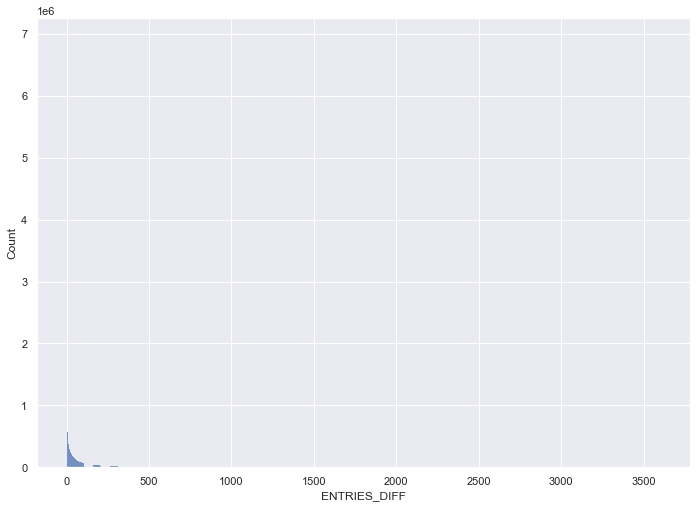

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(df["ENTRIES_DIFF"]);


In [24]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME', 'SUBUNIT', 'CONTROL',
       'POSITION', 'STATIONLINE', 'ENTRIES_DIFF'],
      dtype='object')

In [25]:
df.columns = [f.strip() for f in df.columns]


In [26]:
df["EXITS_DIFF"] = df \
    .groupby(['STATIONLINE', 'C/A', 'UNIT', 'SCP'])['EXITS'] \
    .diff() \
    .fillna(0)


In [27]:
# rows where exits < 0
df.loc[df["EXITS_DIFF"] < 0, "EXITS_DIFF"]

40316         -81225.0
45249         -83502.0
50598        -156825.0
55673        -312893.0
61169        -779407.0
               ...    
36976162     -384726.0
37015018   -26948103.0
37015169      -37533.0
37015822     -179213.0
37015909      -23127.0
Name: EXITS_DIFF, Length: 241152, dtype: float64

In [28]:
df.loc[df["EXITS_DIFF"] < 0, "EXITS_DIFF"]=0

In [29]:
sanity_check = 7200
df.loc[df["EXITS_DIFF"] > sanity_check, "EXITS_DIFF"] = 0

In [30]:
# keep rows with entries or exits > 0
df = df.loc[(df["ENTRIES_DIFF"] > 0) | (df["EXITS_DIFF"] > 0)].copy()

<AxesSubplot:xlabel='EXITS_DIFF', ylabel='Count'>

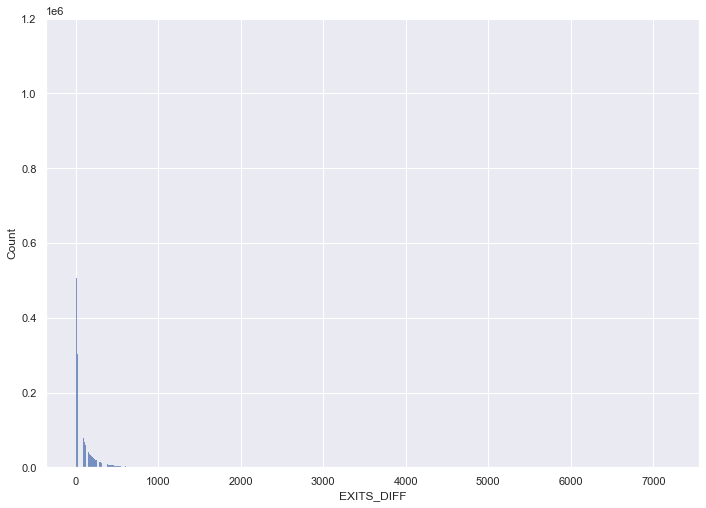

In [31]:
sns.histplot(df["EXITS_DIFF"])


In [32]:
df["DATE2"] = df["DATE_TIME"].dt.date

In [33]:
agg_time = df[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000
agg_time


,DATE2,ENTRIES_DIFF,rolling
0,2019-01-05,2408624.0,NaN
1,2019-01-06,2338588.0,NaN
2,2019-01-07,5369267.0,NaN
3,2019-01-08,5534388.0,NaN
4,2019-01-09,5660990.0,NaN
...,...,...,...
1248,2022-06-06,2300756.0,2.103649
1249,2022-06-07,2496945.0,2.126318
1250,2022-06-08,2557219.0,2.131670
1251,2022-06-09,2388112.0,2.120926


In [34]:
len(df)

32128789

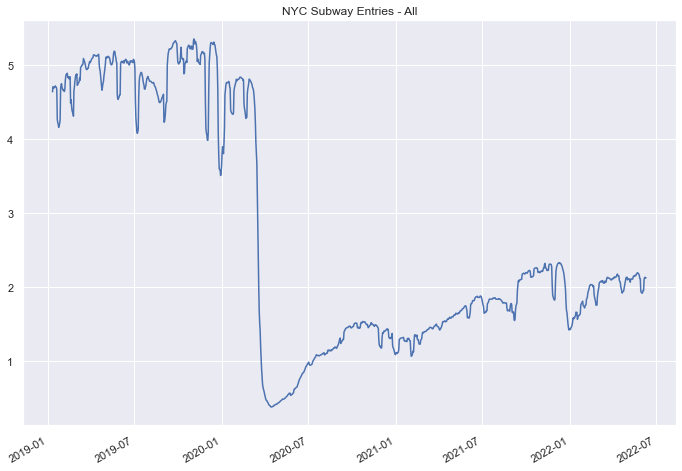

In [35]:
plt.plot(agg_time["DATE2"], agg_time["rolling"])
plt.title("NYC Subway Entries - All")
plt.gcf().autofmt_xdate();


In [36]:
df["STATIONLINE"].unique()

array(['1 AV-L', '103 ST-1', '103 ST-6', '103 ST-BC', '103 ST-CORONA-7',
       '104 ST-A', '104 ST-JZ', '110 ST-6', '111 ST-7', '111 ST-A',
       '111 ST-J', '116 ST-23', '116 ST-6', '116 ST-BC',
       '116 ST-COLUMBIA-1', '121 ST-JZ', '125 ST-1', '125 ST-23',
       '125 ST-456', '125 ST-ABCD', '135 ST-23', '135 ST-BC',
       '137 ST CITY COL-1', '138/GRAND CONC-45', '14 ST-123FLM',
       '14 ST-ACEL', '14 ST-UNION SQ-456LNQRW', '145 ST-1', '145 ST-3',
       '145 ST-ABCD', '149/GRAND CONC-245', '14TH STREET-1',
       '15 ST-PROSPECT-FG', '155 ST-BD', '155 ST-C', '157 ST-1',
       '161/YANKEE STAD-4BD', '163 ST-AMSTERDM-C', '167 ST-4',
       '167 ST-BD', '168 ST-1AC', '169 ST-F', '170 ST-4', '170 ST-BD',
       '174 ST-25', '174-175 STS-BD', '175 ST-A', '176 ST-4', '18 AV-D',
       '18 AV-F', '18 AV-N', '18 ST-1', '181 ST-1', '181 ST-A',
       '182-183 STS-BD', '183 ST-4', '190 ST-A', '191 ST-1', '2 AV-F',
       '20 AV-D', '20 AV-N', '207 ST-1', '21 ST-G', '21 ST-QNSBRIDGE-

In [37]:
cbd_stations = ['1 AV-L',
'14 ST-123FLM',
'14 ST-ACEL',
'14 ST-UNION SQ-456LNQRW',
'14TH STREET-1',
'18 ST-1',
'2 AV-F',
'23 ST-1',
'23 ST-6',
'23 ST-CE',
'23 ST-FM',
'23 ST-NRW',
'28 ST-1',
'28 ST-6',
'28 ST-NRW',
'3 AV-L',
'33 ST-6',
'34 ST-HERALD SQ-BDFMNQRW',
'34 ST-HUDSON YD-7',
'34 ST-PENN STA-123',
'34 ST-PENN STA-123ACE',
'34 ST-PENN STA-ACE',
'42 ST-BRYANT PK-7BDFM',
'42 ST-PORT AUTH-1237ACEGNRSW',
'42 ST-PORT AUTH-1237ACENQRSW',
'47-50 STS ROCK-BDFM',
'49 ST-NQRW',
'5 AV/53 ST-EM',
'5 AV/59 ST-NQRW',
'5 AVE-7BDFM',
'50 ST-1',
'50 ST-CE',
'50 ST-D',
'51 ST-6',
'57 ST-7 AV-NQRW',
'57 ST-F',
'59 ST COLUMBUS-1ABCD',
'59 ST-456NQRW',
'59 ST-NRW',
'6 AV-123FLM',
'7 AV-BDE',
'8 AV-ACEL',
'8 ST-NYU-NRW',
'9TH STREET-1',
'ASTOR PL-6',
"B'WAY-LAFAYETTE-6BDFQ",
'BLEECKER ST-6DF',
'BOWLING GREEN-45',
'BROAD ST-JZ',
'BROOKLYN BRIDGE-456JZ',
'CANAL ST-1',
'CANAL ST-6JNQRWZ',
'CANAL ST-ACE',
'CHAMBERS ST-123',
'CHAMBERS ST-23ACE',
'CHAMBERS ST-456JZ',
'CHRISTOPHER ST-1',
'CITY HALL-NRW',
'CORTLANDT ST-NRW',
'DELANCEY/ESSEX-FJMZ',
'EAST BROADWAY-F',
'EXCHANGE PLACE-1',
'FRANKLIN ST-1',
'FULTON ST-2345ACJZ',
'GRAND ST-BD',
'GRD CNTRL-42 ST-4567S',
'HOUSTON ST-1',
'LEXINGTON AV/53-6EM',
'LEXINGTON AV/63-F',
'PARK PLACE-23ACE',
'PATH NEW WTC-1',
'PATH WTC 2-1',
'PRINCE ST-NRW',
'RECTOR ST-1',
'RECTOR ST-NRW',
'SOUTH FERRY-1RW',
'SPRING ST-6',
'SPRING ST-CE',
'TIMES SQ-42 ST-1237ACENQRS',
'TIMES SQ-42 ST-1237ACENQRSW',
'TWENTY THIRD ST-1',
'W 4 ST-WASH SQ-ABCDEFM',
'WALL ST-23',
'WALL ST-45',
'WHITEHALL S-FRY-1RW',
'WORLD TRADE CTR-23ACE',
'WTC-CORTLANDT-1',
]


In [38]:
# manhattan < 66 st
# before 11am on weekday
cbd_df = df.loc[df["STATIONLINE"].isin(cbd_stations)]
len(cbd_df)

11582193

In [39]:
agg_time = cbd_df[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_time["rolling"] = agg_time.rolling(7).sum()/7/1000000
agg_time


,DATE2,ENTRIES_DIFF,rolling
0,2019-01-05,886122.0,NaN
1,2019-01-06,904380.0,NaN
2,2019-01-07,2194836.0,NaN
3,2019-01-08,2279624.0,NaN
4,2019-01-09,2339239.0,NaN
...,...,...,...
1248,2022-06-06,801201.0,0.742087
1249,2022-06-07,898930.0,0.755347
1250,2022-06-08,920323.0,0.759291
1251,2022-06-09,883168.0,0.760208


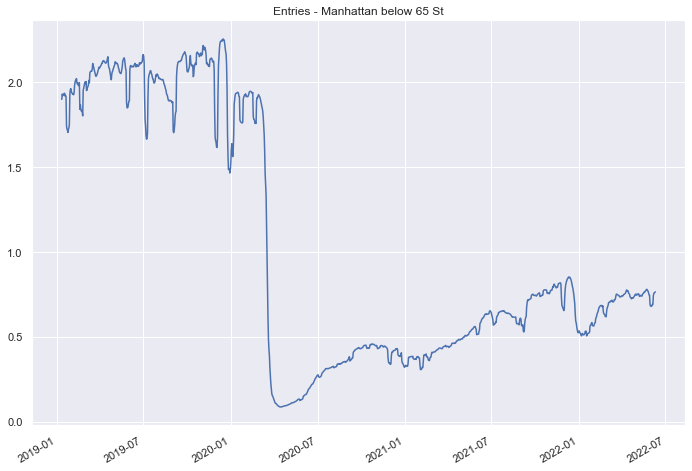

In [40]:
plt.plot(agg_time["DATE2"], agg_time["rolling"])
plt.title("Entries - Manhattan below 65 St")
plt.gcf().autofmt_xdate();


In [41]:
df["weekday"] = df["DATE_TIME"].dt.weekday
df["hour"] = df["DATE_TIME"].dt.hour

morn_df = df.loc[df["weekday"] < 5]
df_am = morn_df.loc[df["hour"] < 12]
df_am

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,DATE_TIME,SUBUNIT,CONTROL,POSITION,STATIONLINE,ENTRIES_DIFF,EXITS_DIFF,DATE2,weekday,hour
12,H007,R248,00-00-00,1 AV,L,BMT,01/07/2019,03:00:00,REGULAR,14293528,...,2019-01-07 03:00:00,00,00,00,1 AV-L,67.0,85.0,2019-01-07,0,3
13,H007,R248,00-00-00,1 AV,L,BMT,01/07/2019,07:00:00,REGULAR,14293622,...,2019-01-07 07:00:00,00,00,00,1 AV-L,94.0,297.0,2019-01-07,0,7
14,H007,R248,00-00-00,1 AV,L,BMT,01/07/2019,11:00:00,REGULAR,14294922,...,2019-01-07 11:00:00,00,00,00,1 AV-L,1300.0,1431.0,2019-01-07,0,11
18,H007,R248,00-00-00,1 AV,L,BMT,01/08/2019,03:00:00,REGULAR,14297399,...,2019-01-08 03:00:00,00,00,00,1 AV-L,70.0,95.0,2019-01-08,1,3
19,H007,R248,00-00-00,1 AV,L,BMT,01/08/2019,07:00:00,REGULAR,14297517,...,2019-01-08 07:00:00,00,00,00,1 AV-L,118.0,361.0,2019-01-08,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37078115,R419,R326,00-05-01,ZEREGA AV,6,IRT,12/08/2021,08:00:00,REGULAR,39,...,2021-12-08 08:00:00,00,05,01,ZEREGA AV-6,0.0,1.0,2021-12-08,2,8
37078120,R419,R326,00-05-01,ZEREGA AV,6,IRT,12/09/2021,04:00:00,REGULAR,39,...,2021-12-09 04:00:00,00,05,01,ZEREGA AV-6,0.0,1.0,2021-12-09,3,4
37078151,R419,R326,00-05-01,ZEREGA AV,6,IRT,12/14/2021,08:00:00,REGULAR,39,...,2021-12-14 08:00:00,00,05,01,ZEREGA AV-6,0.0,3.0,2021-12-14,1,8
37078251,R419,R326,00-05-01,ZEREGA AV,6,IRT,12/31/2021,00:00:00,REGULAR,39,...,2021-12-31 00:00:00,00,05,01,ZEREGA AV-6,0.0,2.0,2021-12-31,4,0


In [42]:
agg_ent = df_am[["DATE2", "ENTRIES_DIFF"]] \
    .groupby(["DATE2"]) \
    .sum() \
    .reset_index()
agg_ent["rolling"] = agg_ent.rolling(7).sum()/7/1000000
agg_ent

,DATE2,ENTRIES_DIFF,rolling
0,2019-01-07,1717624.0,NaN
1,2019-01-08,1843771.0,NaN
2,2019-01-09,1870348.0,NaN
3,2019-01-10,1871540.0,NaN
4,2019-01-11,1784149.0,NaN
...,...,...,...
890,2022-06-06,664425.0,0.647219
891,2022-06-07,733050.0,0.653495
892,2022-06-08,754570.0,0.715852
893,2022-06-09,691158.0,0.716584


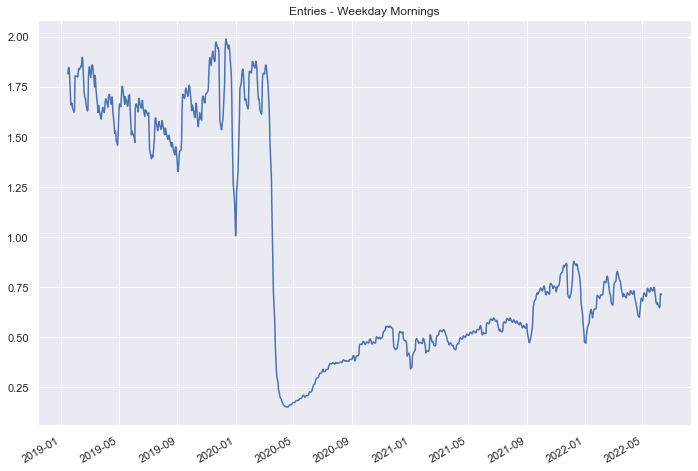

In [43]:
plt.plot(agg_ent["DATE2"], agg_ent["rolling"])
plt.title("Entries - Weekday Mornings")
plt.gcf().autofmt_xdate();


In [44]:
# not used but could be used to filter by borough, rectangle 
geodf = pd.read_csv("https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv?accessType=DOWNLOAD")
geodf

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times"
...,...,...,...,...,...,...
468,http://web.mta.info/nyct/service/,469,Coney Island - Stillwell Av,POINT (-73.9812359981396 40.57728100006751),D-F-N-Q,"D,F,N,Q-all times"
469,http://web.mta.info/nyct/service/,470,34th St - Hudson Yards,POINT (-74.00219709442206 40.75544635961596),7-7 Express,"7-all times, 7 Express-rush hours AM westbound..."
470,http://web.mta.info/nyct/service/,641,72nd St,POINT (-73.95836178682246 40.76880251014895),Q,Q-all times
471,http://web.mta.info/nyct/service/,642,86th St,POINT (-73.95177090964917 40.77786104333163),Q,Q-all times


In [45]:
sorted(geodf.NAME.unique())

['103rd St',
 '103rd St - Corona Plaza',
 '104th St',
 '104th-102nd Sts',
 '110th St',
 '111th St',
 '116th St',
 '116th St - Columbia University',
 '121st St',
 '125th St',
 '135th St',
 '137th St - City College',
 '138th St - Grand Concourse',
 '145th St',
 '149th St - Grand Concourse',
 '14th St',
 '155th St',
 '157th St',
 '15th St - Prospect Park',
 '161st St - Yankee Stadium',
 '163rd St - Amsterdam Av',
 '167th St',
 '168th St',
 '169th St',
 '170th St',
 '174th St',
 '174th-175th Sts',
 '175th St',
 '176th St',
 '181st St',
 '182nd-183rd Sts',
 '183rd St',
 '18th Ave',
 '18th St',
 '190th St',
 '191st St',
 '1st Ave',
 '207th St',
 '20th Ave',
 '215th St',
 '219th St',
 '21st St',
 '21st St - Queensbridge',
 '225th St',
 '231st St',
 '233rd St',
 '238th St',
 '23rd St',
 '25th Ave',
 '25th St',
 '28th St',
 '30th Ave',
 '33rd St',
 '34th St - Hudson Yards',
 '34th St - Penn Station',
 '36th Ave',
 '36th St',
 '39th Ave',
 '3rd Ave',
 '3rd Ave - 138th St',
 '3rd Ave - 149th St',

In [46]:
stationmap = {'1 AV - L': '1st Ave - L',
 '103 ST - 1': '103rd St - 1',
 '103 ST - 6': '103rd St - 4-6-6 Express',
 '103 ST - BC': '103rd St - A-B-C',
 '103 ST-CORONA - 7': '103rd St - Corona Plaza - 7',
 '104 ST - A': '104th St - A-S',
 '104 ST - JZ': '104th-102nd Sts - J-Z',
 '110 ST - 6': '110th St - 4-6-6 Express',
 '111 ST - 7': '111th St - 7',
 '111 ST - A': '111th St - A-S',
 '111 ST - J': '111th St - J',
 '116 ST - 23': '116th St - 2-3',
 '116 ST - 6': '116th St - 4-6-6 Express',
 '116 ST - BC': '116th St - A-B-C',
 '116 ST-COLUMBIA - 1': '116th St - Columbia University - 1',
 '121 ST - JZ': '121st St - J-Z',
 '125 ST - 1': '125th St - 1',
 '125 ST - 23': '125th St - 2-3',
 '125 ST - 456': '125th St - 4-5-6-6 Express',
 '125 ST - ACBD': '125th St - A-B-C-D',
 '135 ST - 23': '135th St - 2-3',
 '135 ST - BC': '135th St - A-B-C',
 '137 ST CITY COL - 1': '137th St - City College - 1',
 '138/GRAND CONC - 45': '138th St - Grand Concourse - 4-5',
 '14 ST - 123FLM': '14th St - F-M',
 '14 ST - ACEL': '14th St - A-C-E',
 '14 ST - FLM123': '14th St - F-M',
 '14 ST-UNION SQ - 456LNQRW': 'Union Sq - 14th St - 4-5-6-6 Express',
 '14 ST-UNION SQ - LNQR456W': 'Union Sq - 14th St - N-Q-R-W',
 '145 ST - 1': '145th St - 1',
 '145 ST - ABCD': '145th St - A-B-C-D',
 '149/GRAND CONC - 245': '149th St - Grand Concourse - 2-5',
 '14TH STREET - 1': '14th St - 1-2-3',
 '15 ST-PROSPECT - FG': '15th St - Prospect Park - F-G',
 '155 ST - BD': '155th St - B-D',
 '155th St - A-C': '155 ST - C',
 '155 ST - C': '155th St - A-C',
 '157 ST - 1': '157th St - 1',
 '161/YANKEE STAD - 4BD': '161st St - Yankee Stadium - 4',
 '161/YANKEE STAD - BD4': '161st St - Yankee Stadium - 4',
 '167 ST - 4': '167th St - 4',
 '168 ST - 1AC': '168th St - 1',
 '168 ST - AC1': '168th St - 1',
 '169 ST - F': '169th St - F',
 '170 ST - 4': '170th St - 4',
 '170 ST - BD': '170th St - B-D',
 '174 ST - 25': '174th St - 2-5',
 '175 ST - A': '175th St - A',
 '176 ST - 4': '176th St - 4',
 '18 AV - D': '18th Ave - D',
 '18 AV - F': '18th Ave - F',
 '18 AV - N': '18th Ave - N',
 '18 ST - 1': '18th St - 1-2',
 '181 ST - 1': '181st St - 1',
 '181 ST - A': '181st St - A',
 '182-183 STS - BD': '182nd-183rd Sts - B-D',
 '183 ST - 4': '183rd St - 4',
 '190 ST - A': '190th St - A',
 '191 ST - 1': '191st St - 1',
 '2 AV - F': 'Lower East Side - 2nd Ave - F',
 '20 AV - D': '20th Ave - D',
 '20 AV - N': '20th Ave - N',
 '207 ST - 1': '207th St - 1',
 '21 ST - G': '21st St - G',
 '21 ST-QNSBRIDGE - F': '21st St - Queensbridge - F',
 '215 ST - 1': '215th St - 1',
 '219 ST - 25': '219th St - 2-5',
 '225 ST - 25': '225th St - 2-5',
 '23 ST - 1': '23rd St - 1-2',
 '23 ST - 6': '23rd St - 4-6-6 Express',
 '23 ST - CE': '23rd St - A-C-E',
 '23 ST - NRW': '23rd St - N-Q-R-W',
 '231 ST - 1': '231st St - 1',
 '233 ST - 25': '233rd St - 2-5',
 '238 ST - 1': '238th St - 1',
 '25 AV - D': '25th Ave - D',
 '25 ST - R': '25th St - D-N-R',
 '28 ST - 1': '28th St - 1-2',
 '28 ST - NRW': '28th St - N-Q-R-W',
 '3 AV - L': '3rd Ave - L',
 '3 AV 138 ST - 6': '3rd Ave - 138th St - 6-6 Express',
 '3 AV-149 ST - 25': '3rd Ave - 149th St - 2-5',
 '30 AV - NQW': '30th Ave - N-W',
 '33 ST - 6': '33rd St - 4-6-6 Express',
 '33 ST-RAWSON ST - 7': '33rd St - 7',
 '34 ST-HERALD SQ - BDFMNQRW': 'Herald Sq - 34th St - B-D-F-M',
 '34 ST-HUDSON YD - 7': '34th St - Hudson Yards - 7-7 Express',
 '34 ST-PENN STA - 123': '34th St - Penn Station - 1-2-3',
 '34 ST-PENN STA - 123ACE': '34th St - Penn Station - A-C-E',
 '34 ST-PENN STA - ACE': '34th St - Penn Station - A-C-E',
 '36 AV - NQW': '36th Ave - N-W',
 '36 ST - DNR': '36th St - D-N-R',
 '36 ST - MR': '36th St - E-M-R',
 '4 AV-9 ST - DFGMNR': '4th Av - 9th St - D-N-R',
 '40 ST LOWERY ST - 7': '40th St - 7',
 '42 ST-BRYANT PK - BDFM7': '42nd St - Bryant Pk - B-D-F-M',
 '42 ST-PORT AUTH - ACENGRS1237W': '42nd St - Port Authority Bus Term - A-C-E',
 '42 ST-PORT AUTH - ACENQRS1237W': '42nd St - Port Authority Bus Term - A-C-E',
 '45 ST - R': '45th St - N-R',
 '46 ST - MR': '46th St - E-M-R',
 '46 ST BLISS ST - 7': '46th St - 7',
 '47-50 STS ROCK - BDFM': '47th-50th Sts - Rockefeller Ctr - B-D-F-M',
 '49 ST - NQRW': '49th St - N-Q-R-W',
 '4AV-9 ST - DFGMNR': '4th Av - 9th St - D-N-R',
 '5 AV/53 ST - EM': '5th Ave - 53rd St - E-M',
 '5 AV/59 ST - NQRW': '5th Ave - 59th St - N-R-W',
 '5 AVE - 7BDFM': '5th Ave - Bryant Pk - 7-7 Express',
 '50 ST - 1': '50th St - 1-2',
 '50 ST - CE': '50th St - A-C-E',
 '50 ST - D': '50th St - D',
 '51 ST - 6': '51st St - 4-6-6 Express',
 '52 ST - 7': '52nd St - 7',
 '53 ST - R': '53rd St - N-R',
 '55 ST - D': '55th St - D',
 '57 ST-7 AV - NQRW': '57th St - N-Q-R-W',
 '59 ST - 456NQRW': 'Lexington Ave - 59th St - 4-5-6-6 Express',
 '59 ST - NQR456W': '59th St - N-R',
 '59 ST - NRW': '59th St - N-R',
 '59 ST COLUMBUS - 1ABCD': '59th St - Columbus Circle - 1-2',
 '59 ST COLUMBUS - ABCD1': '59th St - Columbus Circle - A-B-C-D',
 '6 AV - FLM123': '6th Ave - L',
 '61 ST WOODSIDE - 7': 'Woodside - 61st St - 7-7 Express',
 '63 DR-REGO PARK - MR': '63rd Dr - Rego Park - E-M-R',
 '65 ST - MR': '65th St - E-M-R',
 '66 ST-LINCOLN - 1': '66th St - Lincoln Ctr - 1-2',
 '67 AV - MR': '67th Ave - E-M-R',
 '68ST-HUNTER CO - 6': '68th St - Hunter College - 4-6-6 Express',
 '69 ST - 7': '69th St - 7',
 '7 AV - BDE': '7th Ave - B-D-E',
 '7 AV - BQ': '7th Ave - B-Q',
 '7 AV - FG': '7th Ave - F-G',
 '71 ST - D': '71st St - D',
 '72 ST - 123': '72nd St - 1-2-3',
 '72 ST-2 AVE - Q': '72nd St - Q',
 '74 ST-BROADWAY - 7EFMR': '74th St - Broadway - 7',
 '75 AV - EF': '75th Ave - E-F',
 '75 ST-ELDERTS - JZ': '75th St - Eldert Ln - J-Z',
 '77 ST - 6': '77th St - 4-6-6 Express',
 '77 ST - R': '77th St - R',
 '79 ST - 1': '79th St - 1-2',
 '79 ST - D': '79th St - D',
 '8 AV - ACEL': '8th Ave - L',
 '8 AV - N': '8th St - NYU - N-Q-R-W',
 '8 ST-NYU - NRW': '8th St - NYU - N-Q-R-W',
 '80 ST - A': '80th St - A-S',
 '81 ST-MUSEUM - BC': '81st St - A-B-C',
 '82 ST-JACKSON H - 7': '82nd St - Jackson Hts - 7',
 '85 ST-FOREST PK - J': '85th St - Forest Pky - J',
 '86 ST - 1': '86th St - 1-2',
 '86 ST - 456': '86th St - 4-5-6-6 Express',
 '86 ST - N': '86th St - R',
 '86 ST - R': '86th St - R',
 '86 ST-2 AVE - Q': '86th St - Q',
 '88 ST - A': '88th St - A-S',
 '9 AV - D': '9th Ave - D',
 '90 ST-ELMHURST - 7': '90th St - Elmhurst Av - 7',
 '96 ST - 123': '96th St - 1-2-3',
 '96 ST - 6': '96th St - 4-6-6 Express',
 '96 ST - BC': '96th St - A-B-C',
 '96 ST-2 AVE - Q': '96th St - Q',
 'ALABAMA AV - J': 'Alabama Ave - J',
 'ALLERTON AV - 25': 'Allerton Ave - 2-5',
 'AQUEDUCT N.COND - A': 'Aqueduct - North Conduit Av - A',
 'AQUEDUCT RACETR - A': 'Aqueduct Racetrack - A',
 'ASTOR PL - 6': 'Astor Pl - 4-6-6 Express',
 'ASTORIA BLVD - NQW': 'Astoria Blvd - N-W',
 'ASTORIA DITMARS - NQW': 'Astoria - Ditmars Blvd - N-W',
 'ATL AV-BARCLAY - 2345BDNQR': "Atlantic Av - Barclay's Center - 2-3-4-5",
 'ATL AV-BARCLAY - BDNQR2345': "Atlantic Av - Barclay's Center - B-Q",
 'ATLANTIC AV - L': 'Atlantic Ave - L',
 'AVENUE H - BQ': 'Ave H - Q',
 'AVENUE I - F': 'Ave I - F',
 'AVENUE J - BQ': 'Ave J - Q',
 'AVENUE M - BQ': 'Ave M - Q',
 'AVENUE N - F': 'Ave N - F',
 'AVENUE P - F': 'Ave P - F',
 'AVENUE U - BQ': 'Ave U - Q',
 'AVENUE U - F': 'Ave U - F',
 'AVENUE U - N': 'Ave U - N',
 'AVENUE X - F': 'Ave X - F',
 "B'WAY-LAFAYETTE - BDFQ6": 'Broadway - Lafayette St - B-D-F-M',
 'BAY 50 ST - D': 'Bay 50th St - D',
 'BAY PKWY - D': 'Bay Pky - D',
 'BAY PKWY - F': 'Bay Pky - F',
 'BAY PKWY - N': 'Bay Pky - N',
 'BAY RIDGE AV - R': 'Bay Ridge Ave - R',
 'BAY RIDGE-95 ST - R': 'Bay Ridge - 95th St - R',
 'BAYCHESTER AV - 5': 'Baychester Ave - 5',
 'BEACH 105 ST - AS': 'Beach 105th St - A-S',
 'BEACH 25 ST - A': 'Beach 25th St - A',
 'BEACH 36 ST - A': 'Beach 36th St - A',
 'BEACH 44 ST - A': 'Beach 44th St - A',
 'BEACH 60 ST - A': 'Beach 60th St - A',
 'BEACH 67 ST - A': 'Beach 67th St - A',
 'BEACH 90 ST - AS': 'Beach 90th St - A-S',
 'BEACH 98 ST - AS': 'Beach 98th St - A-S',
 'BEDFORD AV - L': 'Bedford Ave - L',
 'BEDFORD PK BLVD - 4': 'Bedford Park Blvd - Lehman College - 4',
 'BEDFORD PK BLVD - BD': 'Bedford Park Blvd - B-D',
 'BEDFORD-NOSTRAN - G': 'Bedford - Nostrand Aves - G',
 'BERGEN ST - 23': 'Bergen St - 2-3-4',
 'BERGEN ST - FG': 'Bergen St - F-G',
 'BEVERLEY ROAD - BQ': 'Beverly Rd - Q',
 'BEVERLY RD - 25': 'Beverly Rd - 2-5',
 'BLEECKER ST - 6DF': 'Bleecker St - 4-6-6 Express',
 'BOROUGH HALL - 2345R': 'Borough Hall - 2-3',
 'BOROUGH HALL - R2345': 'Borough Hall - 4-5',
 'BOTANIC GARDEN - S2345': 'Botanic Garden - S',
 'BOWERY - JZ': 'Bowery - J-Z',
 'BOWLING GREEN - 45': 'Bowling Green - 4-5',
 'BRIARWOOD - EF': 'Briarwood - Van Wyck Blvd - E-F',
 'BRIGHTON BEACH - BQ': 'Brighton Beach - B-Q',
 'BROAD CHANNEL - AS': 'Broad Channel - A-S',
 'BROAD ST - JZ': 'Broad St - J-Z',
 'BROADWAY - G': 'Broadway - G',
 'BROADWAY JCT - ACJLZ': 'Broadway Junction - A-C',
 'BRONX PARK EAST - 25': 'Bronx Park East - 2-5',
 'BROOK AV - 6': 'Brook Ave - 6',
 'BROOKLYN BRIDGE - 456JZ': 'Brooklyn Bridge - City Hall - 4-5-6-6 Express',
 'BUHRE AV - 6': 'Buhre Ave - 6-6 Express',
 'BURKE AV - 25': 'Burke Ave - 2-5',
 'BURNSIDE AV - 4': 'Burnside Ave - 4',
 'BUSHWICK AV - L': 'Bushwick - Aberdeen - L',
 'CANAL ST - 1': 'Canal St - 1-2',
 'CANAL ST - ACE': 'Canal St - Holland Tunnel - A-C-E',
 'CANAL ST - JNQRZ6W': 'Canal St - 4-6-6 Express',
 'CANARSIE-ROCKAW - L': 'Canarsie - Rockaway Pkwy - L',
 'CARROLL ST - FG': 'Carroll St - F-G',
 'CASTLE HILL AV - 6': 'Castle Hill Ave - 6-6 Express',
 'CATHEDRAL PKWY - 1': 'Cathedral Pkwy (110th St) - 1',
 'CATHEDRAL PKWY - BC': 'Cathedral Pkwy (110th St) - A-B-C',
 'CENTRAL AV - M': 'Central Ave - M',
 'CENTRAL PK N110 - 23': 'Central Park North (110th St) - 2-3',
 'CHAMBERS ST - 123': 'Chambers St - 1-2-3',
 'CHAMBERS ST - ACE23': 'Chambers St - A-C',
 'CHAMBERS ST - JZ456': 'Chambers St - J-Z',
 'CHAUNCEY ST - JZ': 'Chauncey St - J-Z',
 'CHRISTOPHER ST - 1': 'Christopher St - Sheridan Sq - 1-2',
 'CHURCH AV - 25': 'Church Ave - 2-5',
 'CHURCH AV - BQ': 'Church Ave - B-Q',
 'CHURCH AV - FG': 'Church Ave - F-G',
 'CITY HALL - NRW': 'City Hall - R-W',
 'CLARK ST - 23': 'Clark St - 2-3',
 'CLASSON AV - G': 'Classon Ave - G',
 'CLEVELAND ST - J': 'Cleveland St - J',
 'CLINTON-WASH AV - C': 'Clinton - Washington Aves - A-C',
 'CLINTON-WASH AV - G': 'Clinton - Washington Aves - G',
 'CONEY IS-STILLW - DFNQ': 'Coney Island - Stillwell Av - D-F-N-Q',
 'CORTELYOU RD - BQ': 'Cortelyou Rd - Q',
 'CORTLANDT ST - 1': 'Cortlandt St - 1',
 'CORTLANDT ST - RNW': 'Cortlandt St - R-W',
 'COURT SQ - 7': 'Court Sq - 7-7 Express',
 'COURT SQ - EMG': 'Long Island City - Court Sq - G',
 'COURT SQ-23 ST - EMG': 'Court Sq - 23rd St - E-M',
 'CRESCENT ST - JZ': 'Crescent St - J-Z',
 'CROWN HTS-UTICA - 34': 'Crown Hts - Utica Ave - 3-4',
 'CYPRESS AV - 6': 'Cypress Ave - 6',
 'CYPRESS HILLS - J': 'Cypress Hills - J',
 'DEKALB AV - BDNQR': 'DeKalb Ave - B-D-N-Q-R',
 'DEKALB AV - L': 'DeKalb Ave - L',
 'DELANCEY/ESSEX - FJMZ': 'Delancey St - Essex St - F',
 'DITMAS AV - F': 'Ditmas Ave - F',
 'DYCKMAN ST - 1': 'Dyckman St - 1',
 'DYCKMAN ST - A': 'Dyckman St - A',
 "E 143/ST MARY'S - 6": "E 143rd St - St Mary's St - 6",
 'E 149 ST - 6': 'E 149th St - 6',
 'E 180 ST - 25': 'E 180th St - 2-5',
 'EAST 105 ST - L': 'E 105th St - L',
 'EAST BROADWAY - F': 'East Broadway - F',
 'EASTCHSTER/DYRE - 5': 'Eastchester - Dyre Ave - 5',
 'EASTN PKWY-MUSM - 23': 'Eastern Pkwy - Bklyn Museum - 2-3-4',
 'ELDER AV - 6': 'Elder Ave - 6',
 'ELMHURST AV - MR': 'Elmhurst Ave - E-M-R',
 'EUCLID AV - AC': 'Euclid Ave - A-C-S',
 'FAR ROCKAWAY - A': 'Far Rockaway - Mott Ave - A',
 'FLATBUSH AV-B.C - 25': 'Brooklyn College - Flatbush Ave - 2-5',
 'FLUSHING AV - G': 'Flushing Ave - G',
 'FLUSHING AV - JM': 'Flushing Ave - J-M',
 'FLUSHING-MAIN - 7': 'Flushing - Main St - 7-7 Express',
 'FORDHAM RD - 4': 'Fordham Rd - 4',
 'FORDHAM RD - BD': 'Fordham Rd - B-D',
 'FOREST AVE - M': 'Forest Ave - M',
 'FOREST HILLS 71 - EFMR': 'Forest Hills - 71st Av - E-F-M-R',
 'FRANKLIN AV - 2345S': 'Franklin Ave - 2-3-4-5',
 'FRANKLIN AV - ACS': 'Franklin Ave - A-C',
 'FRANKLIN ST - 1': 'Franklin St - 1-2',
 'FREEMAN ST - 25': 'Freeman St - 2-5',
 'FRESH POND RD - M': 'Fresh Pond Rd - M',
 'FT HAMILTON PKY - D': 'Ft Hamilton Pkwy - D',
 'FT HAMILTON PKY - FG': 'Ft Hamilton Pkwy - F-G',
 'FT HAMILTON PKY - N': 'Ft Hamilton Pkwy - N',
 'FULTON ST - 2345ACJZ': 'Fulton St - 2-3',
 'FULTON ST - ACJZ2345': 'Fulton St - 4-5',
 'FULTON ST - G': 'Fulton St - G',
 'GATES AV - JZ': 'Gates Ave - J-Z',
 'GRAHAM AV - L': 'Graham Ave - L',
 'GRAND ARMY PLAZ - 23': 'Grand Army Plaza - 2-3-4',
 'GRAND ST - BD': 'Grand St - B-D',
 'GRAND ST - L': 'Grand St - L',
 'GRAND-NEWTOWN - MR': 'Grand Ave - Newtown - E-M-R',
 'GRANT AV - A': 'Grant Ave - A-S',
 'GREENPOINT AV - G': 'Greenpoint Ave - G',
 'GRD CNTRL-42 ST - 4567S': 'Grand Central - 42nd St - 4-5-6-6 Express',
 'GUN HILL RD - 25': 'Gun Hill Rd - 2-5',
 'GUN HILL RD - 5': 'Gun Hill Rd - 5',
 'HALSEY ST - J': 'Halsey St - J',
 'HALSEY ST - L': 'Halsey St - L',
 'HARLEM 148 ST - 3': 'Harlem - 148 St - 3',
 'HEWES ST - JM': 'Hewes St - J-M',
 'HIGH ST - AC': 'High St - A-C',
 'HOUSTON ST - 1': 'Houston St - 1-2',
 'HOWARD BCH JFK - A': 'Howard Beach - JFK Airport - A',
 'HOYT ST - 23': 'Hoyt St - 2-3',
 'HOYT-SCHER - ACG': 'Hoyt - Schermerhorn Sts - A-C-G',
 'HUNTERS PT AV - 7': 'Hunters Point Ave - 7-7 Express',
 'HUNTS POINT AV - 6': 'Hunts Point Ave - 6-6 Express',
 'INTERVALE AV - 25': 'Intervale Ave - 2-5',
 'INWOOD-207 ST - A': 'Inwood - 207th St - A',
 'JACKSON AV - 25': 'Jackson Ave - 2-5',
 'JAMAICA 179 ST - F': 'Jamaica - 179th St - F',
 'JAMAICA CENTER - EJZ': 'Jamaica Ctr - Parsons / Archer - E-J-Z',
 'JAMAICA VAN WK - E': 'Jamaica - Van Wyck - E',
 'JAY ST-METROTEC - ACF': 'Jay St - MetroTech - A-C-F',
 'JAY ST-METROTEC - R': 'Jay St - MetroTech - N-R',
 'JEFFERSON ST - L': 'Jefferson St - L',
 'JFK JAMAICA CT1 - E': 'Jamaica - Van Wyck - E',
 'JKSN HT-ROOSVLT - EFMR7': 'Jackson Hts - Roosevelt Av - E-F-M-R',
 'JUNCTION BLVD - 7': 'Junction Blvd - 7-7 Express',
 'JUNIUS ST - 3': 'Junius St - 3-4',
 'KEW GARDENS - EF': 'Kew Gardens - Union Tpke - E-F',
 'KINGS HWY - BQ': 'Kings Hwy - B-Q',
 'KINGS HWY - F': 'Kings Hwy - F',
 'KINGS HWY - N': 'Kings Hwy - N',
 'KINGSBRIDGE RD - 4': 'Kingsbridge Rd - 4',
 'KINGSBRIDGE RD - BD': 'Kingsbridge Rd - B-D',
 'KINGSTON AV - 3': 'Kingston Ave - 3-4',
 'KINGSTON-THROOP - C': 'Kingston - Throop Aves - A-C',
 'KNICKERBOCKER - M': 'Knickerbocker Ave - M',
 'KOSCIUSZKO ST - J': 'Kosciuszko St - J',
 'LAFAYETTE AV - C': 'Lafayette Ave - A-C',
 'LEXINGTON AV/53 - EM6': 'Lexington Ave - 53rd St - E-M',
 'LEXINGTON AV/63 - F': 'Lexington Ave - 63rd St - F-Q',
 'LIBERTY AV - C': 'Liberty Ave - A-C',
 'LIVONIA AV - L': 'Livonia Ave - L',
 'LONGWOOD AV - 6': 'Longwood Ave - 6',
 'LORIMER ST - JM': 'Lorimer St - J-M',
 'LORIMER ST - LG': 'Lorimer St - L',
 'MARBLE HILL-225 - 1': 'Marble Hill - 225th St - 1',
 'MARCY AV - JMZ': 'Marcy Ave - J-M-Z',
 'METROPOLITAN AV - GL': 'Metropolitan Ave - G',
 'METROPOLITAN AV - M': 'Middle Village - Metropolitan Ave - M',
 'METS-WILLETS PT - 7': 'Mets - Willets Point - 7-7 Express',
 'MIDDLETOWN RD - 6': 'Middletown Rd - 6-6 Express',
 'MONTROSE AV - L': 'Montrose Ave - L',
 'MORGAN AV - L': 'Morgan Ave - L',
 'MORISN AV/SNDVW - 6': 'Morrison Av - Soundview - 6',
 'MORRIS PARK - 5': 'Morris Park - 5',
 'MOSHOLU PKWY - 4': 'Mosholu Pkwy - 4',
 'MT EDEN AV - 4': 'Mt Eden Ave - 4',
 'MYRTLE AV - JMZ': 'Myrtle Ave - J-M-Z',
 'MYRTLE-WILLOUGH - G': 'Myrtle-Willoughby Aves - G',
 'MYRTLE-WYCKOFF - LM': 'Myrtle - Wyckoff Aves - L',
 'NASSAU AV - G': 'Nassau Ave - G',
 'NECK RD - BQ': 'Neck Rd - Q',
 'NEPTUNE AV - F': 'Neptune Ave - F',
 'NEREID AV - 25': 'Nereid Ave (238 St) - 2-5',
 'NEVINS ST - 2345': 'Nevins St - 2-3-4-5',
 'NEW LOTS - L': 'New Lots Ave - L',
 'NEW LOTS AV - 3': 'New Lots Ave - 3-4',
 'NEW UTRECHT AV - ND': 'New Utrecht Ave - N',
 'NEWKIRK AV - 25': 'Newkirk Ave - 2-5',
 'NEWKIRK PLAZA - BQ': 'Newkirk Ave - B-Q',
 'NORTHERN BLVD - MR': 'Northern Blvd - E-M-R',
 'NORWOOD 205 ST - D': 'Norwood - 205th St - D',
 'NORWOOD AV - JZ': 'Norwood Ave - J-Z',
 'NOSTRAND AV - 3': 'Nostrand Ave - 3-4',
 'NOSTRAND AV - AC': 'Nostrand Ave - A-C',
 'OCEAN PKWY - Q': 'Ocean Pkwy - Q',
 'OZONE PK LEFFRT - A': 'Ozone Park - Lefferts Blvd - A-S',
 'PARK PLACE - 23ACE': 'Park Pl - 2-3',
 'PARK PLACE - S': 'Park Pl - S',
 'PARKCHESTER - 6': 'Parkchester - 6-6 Express',
 'PARKSIDE AV - BQ': 'Parkside Ave - Q',
 'PARSONS BLVD - F': 'Parsons Blvd - F',
 'PELHAM BAY PARK - 6': 'Pelham Bay Park - 6-6 Express',
 'PELHAM PKWY - 25': 'Pelham Pkwy - 2-5',
 'PELHAM PKWY - 5': 'Pelham Pkwy - 5',
 'PENNSYLVANIA AV - 3': 'Pennsylvania Ave - 3-4',
 'PRESIDENT ST - 25': 'President St - 2-5',
 'PRINCE ST - NRW': 'Prince St - N-Q-R-W',
 'PROSPECT AV - 25': 'Prospect Ave - 2-5',
 'PROSPECT AV - R': 'Prospect Ave - D-N-R',
 'PROSPECT PARK - BQS': 'Prospect Park - B-Q-S',
 'QUEENS PLAZA - EMR': 'Queens Plz - E-M-R',
 'QUEENSBORO PLZ - 7NQW': 'Queensboro Plz - 7-7 Express-N-W',
 'RALPH AV - C': 'Ralph Ave - A-C',
 'RECTOR ST - 1': 'Rector St - 1',
 'RECTOR ST - NRW': 'Rector St - R-W',
 'RIT-ROOSEVELT - R': 'Jackson Hts - Roosevelt Av - E-F-M-R',
 'ROCKAWAY AV - 3': 'Rockaway Ave - 3-4',
 'ROCKAWAY AV - C': 'Rockaway Ave - A-C',
 'ROCKAWAY BLVD - A': 'Rockaway Blvd - A-S',
 'ROCKAWAY PARK B - AS': 'Rockaway Park - Beach 116 St - A-S',
 'ROOSEVELT ISLND - F': 'Roosevelt Island - Main St - F',
 'SARATOGA AV - 3': 'Saratoga Ave - 3-4',
 'SENECA AVE - M': 'Seneca Ave - M',
 'SHEEPSHEAD BAY - BQ': 'Sheepshead Bay - B-Q',
 'SHEPHERD AV - C': 'Shepherd Ave - A-C',
 'SIMPSON ST - 25': 'Simpson St - 2-5',
 'SMITH-9 ST - FG': 'Smith - 9th Sts - F-G',
 'SOUTH FERRY - 1RW': 'South Ferry - 1',
 'SPRING ST - 6': 'Spring St - 4-6-6 Express',
 'SPRING ST - CE': 'Spring St - A-C-E',
 'ST LAWRENCE AV - 6': 'St Lawrence Ave - 6',
 'STEINWAY ST - MR': 'Steinway St - E-M-R',
 'STERLING ST - 25': 'Sterling St - 2-5',
 'SUTPHIN BLVD - F': 'Sutphin Blvd - F',
 'SUTPHIN-ARCHER - EJZ': 'Sutphin Blvd - Archer Av - E-J-Z',
 'SUTTER AV - L': 'Sutter Ave - L',
 'SUTTER AV-RUTLD - 3': 'Sutter Ave - Rutland Road - 3-4',
 'TIMES SQ-42 ST - 1237ACENQRS': 'Times Sq - 42nd St - 1-2-3',
 'TIMES SQ-42 ST - 1237ACENQRSW': 'Times Sq - 42nd St - 7-7 Express',
 'TIMES SQ-42 ST - ACENQRS1237W': 'Times Sq - 42nd St - N-Q-R-W',
 'TREMONT AV - BD': 'Tremont Ave - B-D',
 'TWENTY THIRD ST - 1': '23rd St - 1-2',
 'UNION ST - R': 'Union St - D-N-R',
 'UTICA AV - AC': 'Utica Ave - A-C',
 'V.CORTLANDT PK - 1': 'Van Cortlandt Park - 242nd St - 1',
 'VAN SICLEN AV - 3': 'Van Siclen Ave - 3-4',
 'VAN SICLEN AV - JZ': 'Van Siclen Ave - J-Z',
 'VAN SICLEN AVE - C': 'Van Siclen Ave - A-C',
 'VERNON-JACKSON - 7': 'Vernon Blvd - Jackson Ave - 7-7 Express',
 'W 4 ST-WASH SQ - ABCDEFM': 'W 4th St - Washington Sq (Lower) - B-D-F-M',
 'W 8 ST-AQUARIUM - FQ': 'W 8th St - NY Aquarium - F-Q',
 'WAKEFIELD/241 - 2': 'Wakefield - 241st St - 2',
 'WALL ST - 23': 'Wall St - 2-3',
 'WALL ST - 45': 'Wall St - 4-5',
 'WEST FARMS SQ - 25': 'West Farms Sq - E Tremont Av - 2-5',
 'WESTCHESTER SQ - 6': 'Westchester Sq - E Tremont Ave - 6-6 Express',
 'WHITEHALL S-FRY - R1W': 'Whitehall St - R-W',
 'WHITLOCK AV - 6': 'Whitlock Ave - 6',
 'WILSON AV - L': 'Wilson Ave - L',
 'WINTHROP ST - 25': 'Winthrop St - 2-5',
 'WOODHAVEN BLVD - JZ': 'Woodhaven Blvd - J-Z',
 'WOODHAVEN BLVD - MR': 'Woodhaven Blvd - Queens Mall - E-M-R',
 'WOODLAWN - 4': 'Woodlawn - 4',
 'WORLD TRADE CTR - ACE23': 'World Trade Center - E',
 'YORK ST - F': 'York St - F',
 'ZEREGA AV - 6': 'Zerega Ave - 6-6 Express',
 'ORCHARD BEACH - 6': '',
 'NEWARK HW BMEBE - 1': '',
 'HARRISON - 1': '',
 'JOURNAL SQUARE - 1': '',
 'GROVE STREET - 1': '',
 'EXCHANGE PLACE - 1': '',
 'PAVONIA/NEWPORT - 1': '',
 'CITY / BUS - 1': '',
 '9TH STREET - 1': '',
 'THIRTY ST - 1': '',
 'LACKAWANNA - 1': '',
 'THIRTY THIRD ST - 1': '',
 'NEWARK BM BW - 1': '',
 'NEWARK C - 1': '',
 'NEWARK HM HE - 1': '',
 'PATH WTC 2 - 1': '',
 'PATH NEW WTC - 1': '',
 'ST. GEORGE - 1': '',
 'TOMPKINSVILLE - 1': ''}
stationmap

{'1 AV - L': '1st Ave - L',
 '103 ST - 1': '103rd St - 1',
 '103 ST - 6': '103rd St - 4-6-6 Express',
 '103 ST - BC': '103rd St - A-B-C',
 '103 ST-CORONA - 7': '103rd St - Corona Plaza - 7',
 '104 ST - A': '104th St - A-S',
 '104 ST - JZ': '104th-102nd Sts - J-Z',
 '110 ST - 6': '110th St - 4-6-6 Express',
 '111 ST - 7': '111th St - 7',
 '111 ST - A': '111th St - A-S',
 '111 ST - J': '111th St - J',
 '116 ST - 23': '116th St - 2-3',
 '116 ST - 6': '116th St - 4-6-6 Express',
 '116 ST - BC': '116th St - A-B-C',
 '116 ST-COLUMBIA - 1': '116th St - Columbia University - 1',
 '121 ST - JZ': '121st St - J-Z',
 '125 ST - 1': '125th St - 1',
 '125 ST - 23': '125th St - 2-3',
 '125 ST - 456': '125th St - 4-5-6-6 Express',
 '125 ST - ACBD': '125th St - A-B-C-D',
 '135 ST - 23': '135th St - 2-3',
 '135 ST - BC': '135th St - A-B-C',
 '137 ST CITY COL - 1': '137th St - City College - 1',
 '138/GRAND CONC - 45': '138th St - Grand Concourse - 4-5',
 '14 ST - 123FLM': '14th St - F-M',
 '14 ST - ACEL'